# Configuración Inicial

## Habilitar GPU (solo para Google Colab)

En la barra superior:

1.   Entorno de ejecución
2.   Cambiar tipo de entorno de ejecución -> GPU


## Subir *dataset* (solo para Google Colab)

In [1]:
### QUITAR COMENTARIOS Y EJECUTAR PARA USAR EN GOOGLE COLAB ###
#from google.colab import files

#uploaded = files.upload()  # Seleccionar el archivo desde el sistema local

# 1 Procesamiento de datos

## 1.1 Carga y exploración inicial

### 1.1.1 Carga del dataset y visualización inicial

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv("Housing.csv")  # Asegurarse de tener el archivo en el directorio local, o subirlo manualmente a Google Colab

In [3]:
# Visualizar primeras filas
print("Primeras 5 filas:")
print(df.head())

# Verificar valores nulos
print("\nValores faltantes por columna:")
df.isnull().sum()

Primeras 5 filas:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Valores faltantes por columna:


price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

No hay valores faltantes en ninguna columna. Por tanto, no es necesario hacer tratamiento de valores nulos.

### 1.1.2 Análisis de distribuciones y outliers

Graficar histogramas y diagramas de caja:

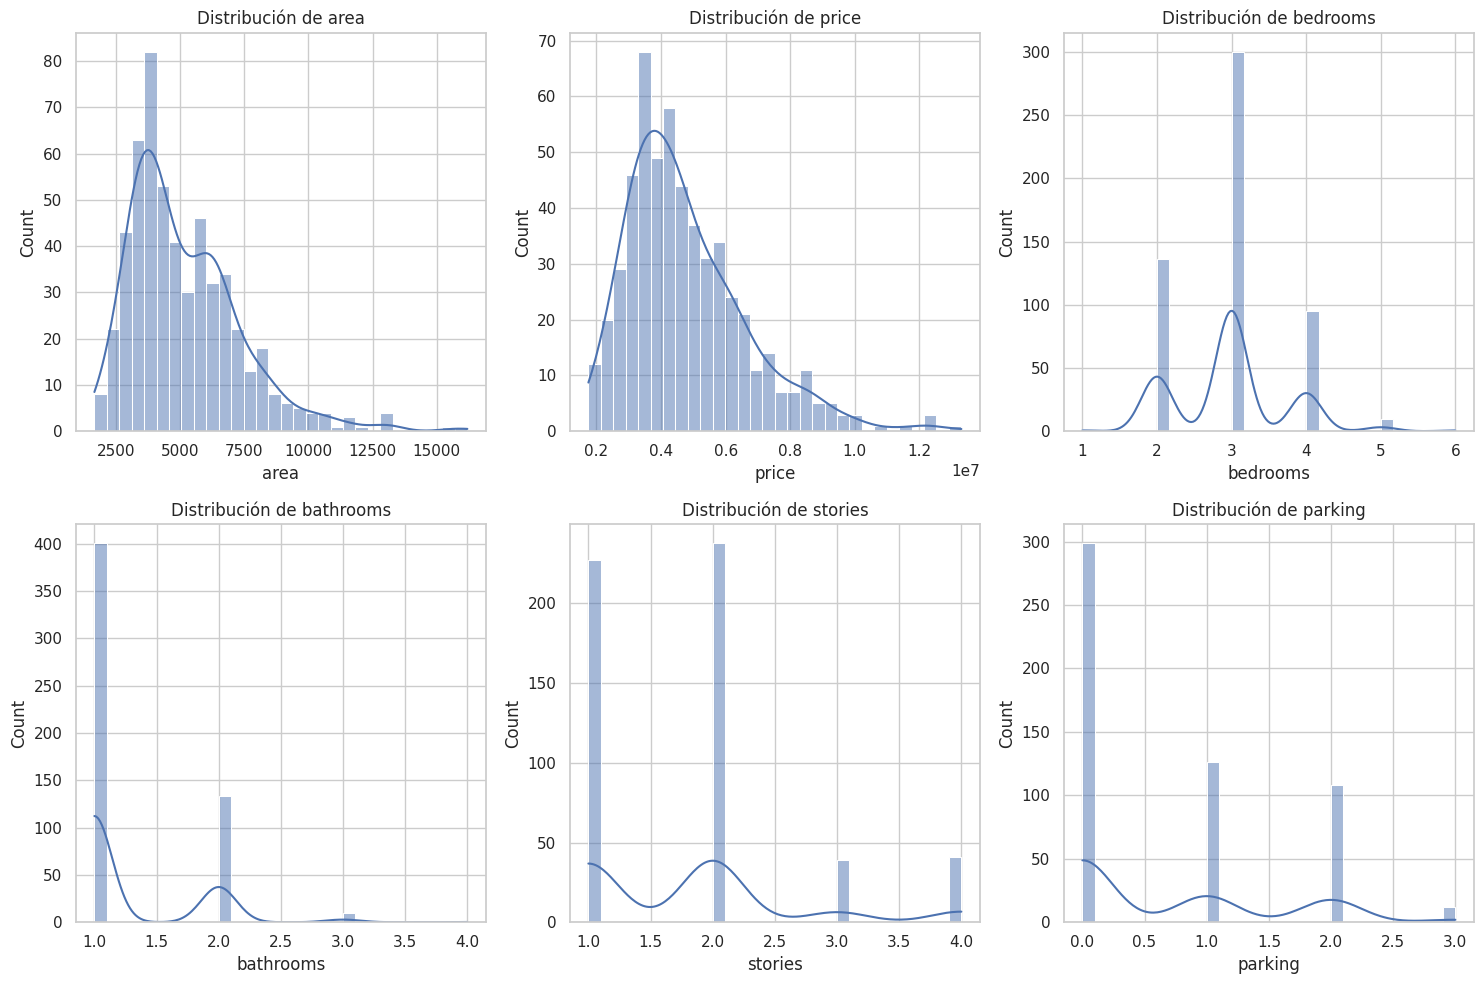

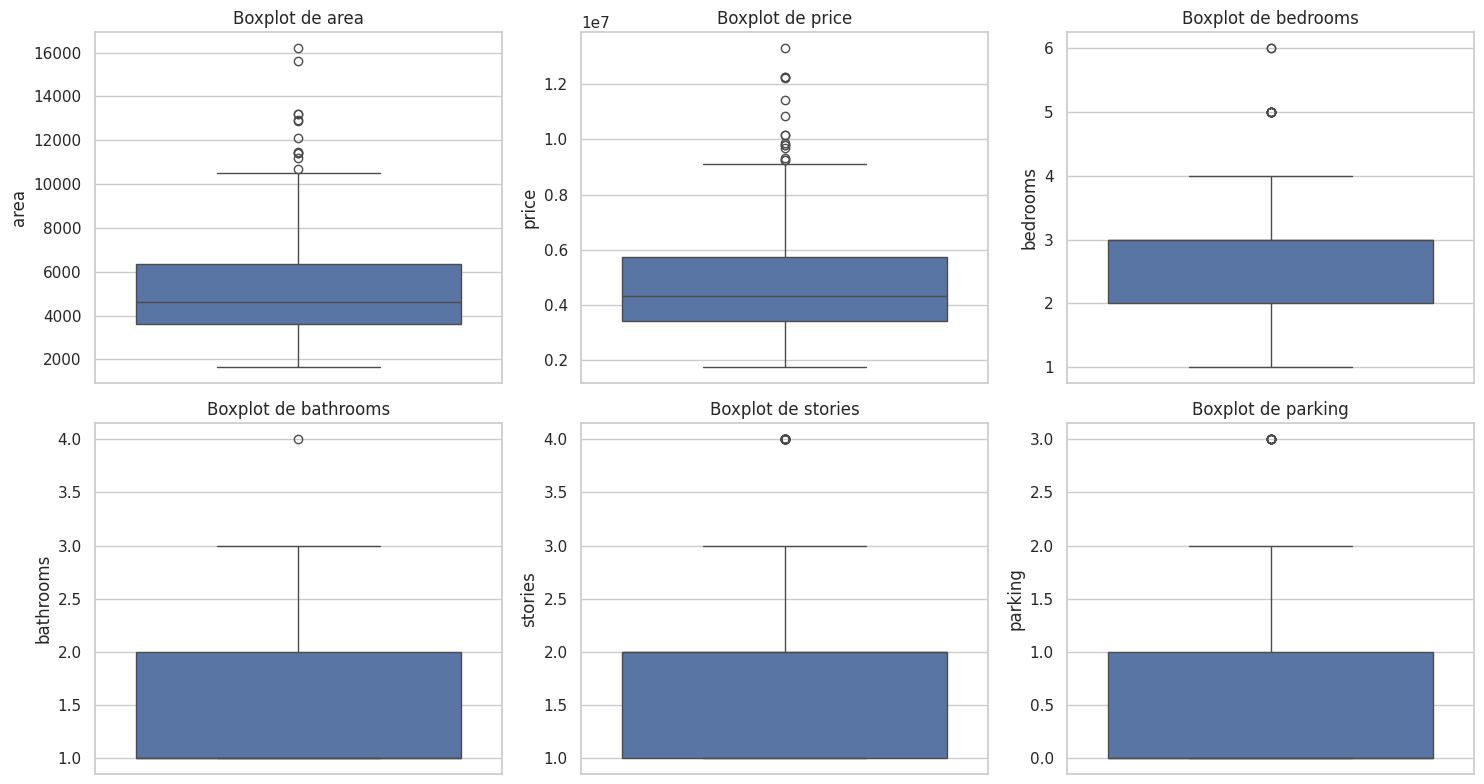

In [4]:
# Configurar estilo de gráficos
sns.set_theme(style="whitegrid")

# Histogramas para variables numéricas
numerical_cols = ['area', 'price', 'bedrooms', 'bathrooms', 'stories', 'parking']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

# Boxplots para detectar outliers
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

- **Histogramas**:

    Muestran la distribución de cada variable numérica.

    Si la distribución tiene una cola larga a la derecha (**sesgo positivo**), significa que hay valores extremadamente altos. En este caso, sucede con `area` y `price`.

- **Boxplots**:

    Identifican valores **atípicos** (_outliers_) en cada variable.

    Los puntos fuera de los "bigotes" (líneas horizontales) son _outliers_. De nuevo, `area` y `price` tienen varios, lo que sugiere que hay propiedades con áreas mucho más grandes que el resto, y con un precio también mucho mayor a los demás.

## 1.2 Preprocesamiento de datos

### 1.2.1 Codificación de variables categóricas

- **Binarias**: `1` para "_yes_", `0` para "_no_".

- ¿Por qué es mejor One-Hot Encoding que Label Encoding en este caso?

    1. Evita jerarquías artificiales:

        La red neuronal podría interpretar erróneamente que unfurnished (0) < semi-furnished (1) < furnished (2), lo que no necesariamente refleja la realidad en los precios.

    2. Flexibilidad del modelo:

        Con One-Hot, cada categoría se trata como una característica independiente, permitiendo al modelo aprender contribuciones no lineales.

    3. Ejemplo práctico:

        Una propiedad semi-furnished no es el "punto medio" entre unfurnished y furnished en términos de precio. One-Hot captura mejor esta relación.

In [5]:
# Variables binarias (yes/no)
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df[binary_cols] = df[binary_cols].replace({'yes': 1, 'no': 0})

# One-Hot Encoding para furnishingstatus
df = pd.get_dummies(df, columns=['furnishingstatus'], prefix='furnishing', dtype=int)

/tmp/ipykernel_5927/56217782.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace({'yes': 1, 'no': 0})


In [6]:
# Verificar cambios
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishing_furnished,furnishing_semi-furnished,furnishing_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0,0
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,0,1,0
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,0,1,0
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0,0,1
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1,0,0
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0,0,1


---

Calcular la media y la desviación estándar del precio antes de normalizar los datos, para después tener estos valores en la API. De esta manera, la API puede desnormalizar los datos para devolver los precios reales:

In [7]:
mean_price = df['price'].mean()
std_price = df['price'].std()
print(f"\nMedia del precio: {mean_price}")
print(f"Desviación estándar del precio: {std_price}")


Media del precio: 4766729.247706422
Desviación estándar del precio: 1870439.6156573922


Tamaño original del dataset: 530 filas
Outliers eliminados: 15 filas
Tamaño del dataset limpio: 530 filas


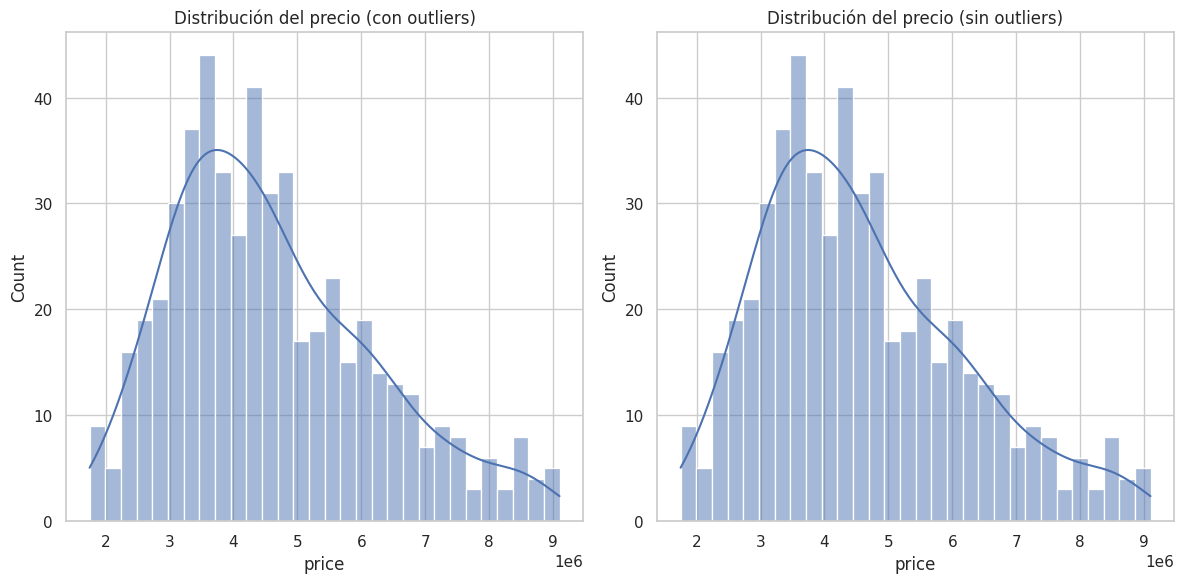

In [8]:
# Calcula los límites para identificar outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define el límite superior e inferior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifica filas con outliers en precio
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Visualiza la diferencia
print(f"Tamaño original del dataset: {df.shape[0]} filas")
print(f"Outliers eliminados: {outliers.shape[0]} filas")
print(f"Tamaño del dataset limpio: {df.shape[0]} filas")

# Visualiza histograma del precio antes y después
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribución del precio (con outliers)')

plt.subplot(1, 2, 2)
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribución del precio (sin outliers)')

plt.tight_layout()
plt.show()

In [9]:
# Verificar cambios
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishing_furnished,furnishing_semi-furnished,furnishing_unfurnished
15,9100000,6000,4,1,2,1,0,1,0,0,2,0,0,1,0
16,9100000,6600,4,2,2,1,1,1,0,1,1,1,0,0,1
17,8960000,8500,3,2,4,1,0,0,0,1,2,0,1,0,0
18,8890000,4600,3,2,2,1,1,0,0,1,2,0,1,0,0
19,8855000,6420,3,2,2,1,0,0,0,1,1,1,0,1,0
20,8750000,4320,3,1,2,1,0,1,1,0,2,0,0,1,0
21,8680000,7155,3,2,1,1,1,1,0,1,2,0,0,0,1
22,8645000,8050,3,1,1,1,1,1,0,1,1,0,1,0,0
23,8645000,4560,3,2,2,1,1,1,0,1,1,0,1,0,0
24,8575000,8800,3,2,2,1,0,0,0,1,2,0,1,0,0


In [10]:
mean_price = df['price'].mean()
std_price = df['price'].std()
print(f"\nMedia del precio: {mean_price}")
print(f"Desviación estándar del precio: {std_price}")


Media del precio: 4600663.094339622
Desviación estándar del precio: 1596119.2128020546


### 1.2.2 Normalización de Variables Numéricas

`StandardScaler` centra las variables en 0 con **desviación estándar** 1. De esta forma, evita que variables como `area` (valores grandes) dominen el modelo.

In [11]:
from sklearn.preprocessing import StandardScaler

# Separar variables numéricas
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']
X_numerical = df[numerical_cols]

# Escalado (usando StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Reemplazar columnas originales con valores escalados
df[numerical_cols] = X_scaled

In [12]:
# Verificar cambios
df[numerical_cols].head()

,area,bedrooms,bathrooms,stories,parking,price
15,0.452609,1.447749,-0.561254,0.245614,1.585532,2.821586
16,0.741976,1.447749,1.594286,0.245614,0.398622,2.821586
17,1.658306,0.077558,1.594286,2.570175,1.585532,2.733790
18,-0.222581,0.077558,1.594286,0.245614,1.585532,2.689893
19,0.655166,0.077558,1.594286,0.245614,0.398622,2.667944


## 1.3 Análisis de correlación

### 1.3.1 Matriz de correlación

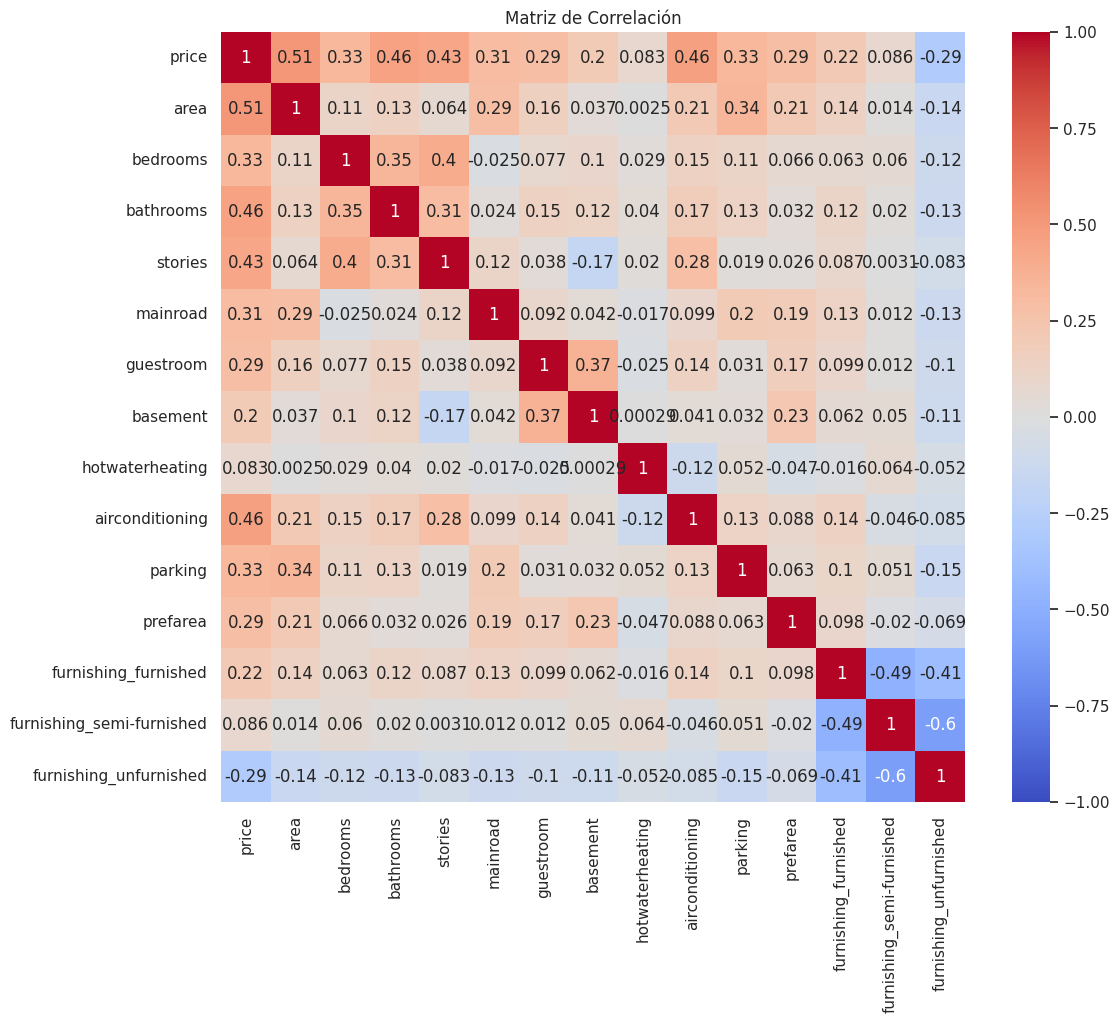

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular matriz de correlación
corr_matrix = df.corr()

# Matriz de correlación para todas las variables
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.show()

También se puede evaluar sólo la columna de la **matriz de correlación** en función de `price`:

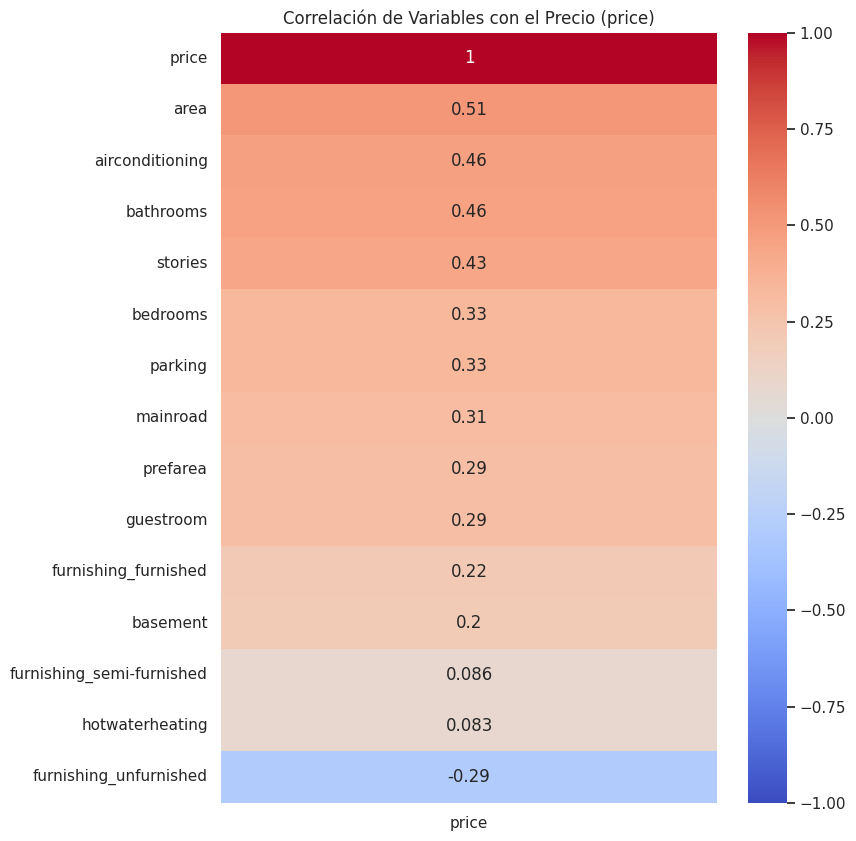

In [14]:
# Filtrar solo las correlaciones con 'price'
price_corr = corr_matrix[['price']].sort_values(by='price', ascending=False)

# Gráfico de correlaciones con 'price'
plt.figure(figsize=(8, 10))
sns.heatmap(price_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlación de Variables con el Precio (price)")
plt.show()

Variables Fuertemente Correlacionadas con `price`:

- Alta correlación **positiva** (`> 0.4`): `area`, `bathrooms`, `airconditioning`: A mayor área, número de baños y/o con aire acondicionado, mayor precio.

- Correlación **negativa** (`< -0.3`): `furnishing_unfurnished`: Las propiedades no amuebladas tienden a ser más baratas.

- **Poca** o casi ninguna correlación:

    - `hotwaterheating` (`0.093`): Saber si una casa tiene o no agua caliente, aporta muy poca información sobre el precio de la misma.

    - `furnishing_semi-furnished` (`0.064`): Que una casa esté "semiamueblada" tiene un impacto mínimo en el precio.

### 1.3.2 Eliminación de variables

Con la información que se ha obtenido al realizar el análisis anterior, se pueden sacar las siguientes **conclusiones**:

- `hotwaterheating`: Se puede **eliminar** esta columna, ya que su correlación con `price` es muy baja, y no aporta información significativa al modelo.

- `furnishing_semi-furnished`: **No** se va a eliminar esta columna, ya que podría carecer de lógica que una vivienda tuviera valor 0 en las otras dos categorías de `furnishing`.

In [15]:
# Eliminar la columna hotwaterheating
df.drop('hotwaterheating', axis=1, inplace=True)

# Verificar el dataset actualizado
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'airconditioning', 'parking', 'prefarea',
       'furnishing_furnished', 'furnishing_semi-furnished',
       'furnishing_unfurnished'],
      dtype='object')

## 1.4 División Train-Test

Creación de datos sintéticos (Data Augmentation):

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

# Separar características (X) y variable objetivo (y)
X = df.drop('price', axis=1)  # Todas las columnas excepto 'price'
y = df['price']  # Columna 'price' como variable objetivo

def augment_data(X, y, num_samples=350):
    np.random.seed(42)
    
    # Interpolación entre puntos reales
    idx1 = np.random.randint(0, len(X), num_samples)
    idx2 = np.random.randint(0, len(X), num_samples)
    
    alpha = np.random.uniform(0, 1, num_samples).reshape(-1, 1)
    X_aug = alpha * X.iloc[idx1].values + (1 - alpha) * X.iloc[idx2].values
    y_aug = alpha.flatten() * y.iloc[idx1].values + (1 - alpha.flatten()) * y.iloc[idx2].values
    
    # Agregar ruido gaussiano
    noise_X = np.random.normal(0, 0.01, X_aug.shape)
    noise_y = np.random.normal(0, 0.01, y_aug.shape)
    
    X_aug += noise_X
    y_aug += noise_y
    
    X_aug = pd.DataFrame(X_aug, columns=X.columns)
    y_aug = pd.Series(y_aug, name=y.name)
    
    return X_aug, y_aug

# Aplicar aumentación
X_aug, y_aug = augment_data(X, y, num_samples=500)
X = pd.concat([X, X_aug], axis=0)
y = pd.concat([y, y_aug], axis=0)

Se utiliza `train_test_split` para dividir el conjunto de datos en 80% datos de entrenamiento y 20% datos de prueba.

In [17]:
# División: 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Verificar tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (824, 13)
Tamaño del conjunto de prueba: (206, 13)


In [19]:
X_train.head(), y_train.head()

(         area  bedrooms  bathrooms   stories  mainroad  guestroom  basement  \
 465  2.373005  1.203386  -0.138780  0.268122  1.011477  -0.003954  0.995873   
 522 -1.247423  0.077558  -0.561254  0.245614  1.000000   0.000000  0.000000   
 349 -0.116479  0.077558  -0.561254  0.245614  1.000000   0.000000  0.000000   
 318  0.055757  0.069542   0.098103  1.840851  1.009325   0.002201  0.003085   
 309 -0.207148  1.447749  -0.561254  0.245614  1.000000   0.000000  0.000000   
 
      airconditioning   parking  prefarea  furnishing_furnished  \
 465        -0.004679  0.642032  0.810496              0.012692   
 522         0.000000 -0.788287  0.000000              1.000000   
 349         0.000000 -0.788287  0.000000              0.000000   
 318         0.698076 -0.423355  0.688356              0.011297   
 309         1.000000 -0.788287  0.000000              0.000000   
 
      furnishing_semi-furnished  furnishing_unfurnished  
 465                   1.011914                0.001895 

# 2 Model Planning

Asegurarse de que `TensorFlow` esté usando la GPU:

In [20]:
import tensorflow as tf

print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

2025-03-27 09:31:26.709908: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 09:31:26.738605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743064286.754439    5927 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743064286.759198    5927 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743064286.776225    5927 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2.1 Construcción del modelo

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal

# Función para crear el modelo con opciones de regularización y Dropout
def create_model(optimizer, dropout_rate=0.0, l2_reg=0.0, n_units=64):
    model = Sequential([
        Dense(n_units, activation='relu', input_shape=(X_train.shape[1],),
              kernel_initializer=HeNormal(), kernel_regularizer=l2(l2_reg)),  # He normal initialization
        BatchNormalization(),
        Dropout(dropout_rate),  # Dropout para evitar sobreajuste
        Dense(n_units, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(n_units // 2, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(l2_reg)),
        Dense(1, activation='linear')  # Capa de salida
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

## 2.2 Comparativa de optimizadores y validación cruzada

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración de K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Diccionarios para almacenar métricas
metrics_adam = {'mae': [], 'rmse': [], 'r2': []}
metrics_sgd  = {'mae': [], 'rmse': [], 'r2': []}

# Iterar sobre cada partición del K-Fold
for train_index, val_index in kf.split(X_train):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_val_fold = y_train.iloc[val_index]

    # --- Modelo con Adam y Gradient Clipping ---
    model_adam = create_model(Adam(learning_rate=0.001, clipvalue=0.5))
    model_adam.fit(
        X_train_fold, 
        y_train_fold, 
        validation_data=(X_val_fold, y_val_fold),
        epochs=100, 
        batch_size=32, 
        verbose=0
    )
    y_pred_adam = model_adam.predict(X_val_fold).flatten()

    # Cálculo de métricas para Adam
    metrics_adam['mae'].append(mean_absolute_error(y_val_fold, y_pred_adam))
    metrics_adam['rmse'].append(np.sqrt(mean_squared_error(y_val_fold, y_pred_adam)))
    metrics_adam['r2'].append(r2_score(y_val_fold, y_pred_adam))

    # --- Modelo con SGD y Gradient Clipping ---
    model_sgd = create_model(SGD(learning_rate=0.01, momentum=0.9, clipvalue=0.5))
    model_sgd.fit(
        X_train_fold,
        y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=100,
        batch_size=32,
        verbose=0
    )
    y_pred_sgd = model_sgd.predict(X_val_fold).flatten()

    # Cálculo de métricas para SGD
    metrics_sgd['mae'].append(mean_absolute_error(y_val_fold, y_pred_sgd))
    metrics_sgd['rmse'].append(np.sqrt(mean_squared_error(y_val_fold, y_pred_sgd)))
    metrics_sgd['r2'].append(r2_score(y_val_fold, y_pred_sgd))

# Resultados promedio
print("Resultados Adam (Cross-Validation):")
print(f"MAE: {np.mean(metrics_adam['mae']):.4f} ± {np.std(metrics_adam['mae']):.4f}")
print(f"RMSE: {np.mean(metrics_adam['rmse']):.4f} ± {np.std(metrics_adam['rmse']):.4f}")
print(f"R²: {np.mean(metrics_adam['r2']):.4f} ± {np.std(metrics_adam['r2']):.4f}")

print("\nResultados SGD (Cross-Validation):")
print(f"MAE: {np.mean(metrics_sgd['mae']):.4f} ± {np.std(metrics_sgd['mae']):.4f}")
print(f"RMSE: {np.mean(metrics_sgd['rmse']):.4f} ± {np.std(metrics_sgd['rmse']):.4f}")
print(f"R²: {np.mean(metrics_sgd['r2']):.4f} ± {np.std(metrics_sgd['r2']):.4f}")

# Evaluación final en test set (opcional)
final_model = create_model(Adam(learning_rate=0.0001, clipvalue=1.0))
final_model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=0)
y_test_pred = final_model.predict(X_test).flatten()

print("\nEvaluación final en Test Set:")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"R²: {r2_score(y_test, y_test_pred):.4f}")

I0000 00:00:1743064302.313676    5927 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743064305.209776    6307 service.cc:152] XLA service 0x7f561c01ff70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743064305.209829    6307 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-03-27 09:31:45.29668

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Resultados Adam (Cross-Validation):
MAE: 0.3529 ± 0.0284
RMSE: 0.5046 ± 0.0347
R²: 0.6897 ± 0.0186

Resultados SGD (Cross-Validation):
MAE: 0.3568 ± 0.0212
RMSE: 0.5056 ± 0.0153
R²: 0.6859 ± 0.0342


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Evaluación final en Test Set:
MAE: 0.3552
RMSE: 0.4700
R²: 0.7482


## 2.3 Entrenamiento del modelo

In [23]:
# Dividir datos en entrenamiento y validación (80%-20%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Crear el modelo con el optimizador Adam
model_adam = create_model(optimizer=Adam(learning_rate=0.001), dropout_rate=0.3, l2_reg=0.01)

# Entrenar el modelo
history = model_adam.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=350,
    batch_size=32,
    verbose=1
)

Epoch 1/350


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 5.5793 - mae: 1.1678 - val_loss: 3.8794 - val_mae: 0.6690
Epoch 2/350
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5049 - mae: 0.9264 - val_loss: 3.7474 - val_mae: 0.6187
Epoch 3/350
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0805 - mae: 0.7830 - val_loss: 3.6738 - val_mae: 0.6067
Epoch 4/350
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9447 - mae: 0.7471 - val_loss: 3.6202 - val_mae: 0.5976
Epoch 5/350
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7559 - mae: 0.6948 - val_loss: 3.5231 - val_mae: 0.5617
Epoch 6/350
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5924 - mae: 0.6406 - val_loss: 3.4337 - val_mae: 0.5435
Epoch 7/350
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4263 - mae: 0.5682 - val_loss: 3.3497 - val_mae: 0.5298
Epoch 8/350
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4396 - mae: 0.6070 - val_loss: 3.2935 - val_mae: 0.5183
Epoch 9/350
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3448 - mae: 0.

## 2.4 Definición de la arquitectura final del modelo

In [24]:
# Arquitectura del modelo con optimizador como argumento
def create_model(optimizer, dropout_rate, l2_reg):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),                                                               # Capa de entrada (12 features)
        Dense(64, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(l2_reg)),     # Primera capa oculta
        BatchNormalization(),                                                                           # Normalización por lotes
        Dropout(dropout_rate),                                                                          # Regularización por Dropout
        Dense(64, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(l2_reg)),     # Segunda capa oculta
        BatchNormalization(),                                                                           # Ayuda con la estabilidad
        Dropout(dropout_rate),                                                                          # Regularización por Dropout
        Dense(32, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(l2_reg)),     # Tercera capa oculta
        Dense(1, activation='linear')                                                                   # Capa de salida con activación lineal
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# 3 Model building and selection

## 3.1 Experimentar con distintos hiperparámetros

In [25]:
# Experimentación con diferentes hiperparámetros
def experiment_with_hyperparameters():
    results = {}
    for lr in [0.01, 0.001, 0.0001]:
        for batch_size in [16, 32, 64]:
            for dropout in [0.2, 0.3]:
                for l2_reg in [0.1, 0.01]:
                    print(f"Entrenando con lr={lr}, batch_size={batch_size}, dropout={dropout}, l2_reg={l2_reg}")
                    model = create_model(optimizer=Adam(learning_rate=lr), dropout_rate=dropout, l2_reg=l2_reg)
                    history = model.fit(
                        X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=350,
                        batch_size=batch_size,
                        verbose=0
                    )
                    val_loss = history.history['val_loss'][-1]
                    results[(lr, batch_size, dropout, l2_reg)] = val_loss
    return results

# Ejecutar experimentos
hyperparameter_results = experiment_with_hyperparameters()

Entrenando con lr=0.01, batch_size=16, dropout=0.2, l2_reg=0.1
Entrenando con lr=0.01, batch_size=16, dropout=0.2, l2_reg=0.01
Entrenando con lr=0.01, batch_size=16, dropout=0.3, l2_reg=0.1
Entrenando con lr=0.01, batch_size=16, dropout=0.3, l2_reg=0.01
Entrenando con lr=0.01, batch_size=32, dropout=0.2, l2_reg=0.1
Entrenando con lr=0.01, batch_size=32, dropout=0.2, l2_reg=0.01
Entrenando con lr=0.01, batch_size=32, dropout=0.3, l2_reg=0.1
Entrenando con lr=0.01, batch_size=32, dropout=0.3, l2_reg=0.01
Entrenando con lr=0.01, batch_size=64, dropout=0.2, l2_reg=0.1
Entrenando con lr=0.01, batch_size=64, dropout=0.2, l2_reg=0.01
Entrenando con lr=0.01, batch_size=64, dropout=0.3, l2_reg=0.1
Entrenando con lr=0.01, batch_size=64, dropout=0.3, l2_reg=0.01
Entrenando con lr=0.001, batch_size=16, dropout=0.2, l2_reg=0.1
Entrenando con lr=0.001, batch_size=16, dropout=0.2, l2_reg=0.01
Entrenando con lr=0.001, batch_size=16, dropout=0.3, l2_reg=0.1
Entrenando con lr=0.001, batch_size=16, dropo

Para obtener la mejor combinación de hiperparámetros:

In [26]:
# Ordenar resultados del experimento por menor pérdida de validación (val_loss)
sorted_results = sorted(hyperparameter_results.items(), key=lambda x: x[1])

# Mostrar las 5 mejores combinaciones
print("Top 5 mejores combinaciones de hiperparámetros:")
for params, val_loss in sorted_results[:5]:
    print(f"LR: {params[0]}, Batch Size: {params[1]}, Dropout: {params[2]}, L2: {params[3]} --> Val Loss: {val_loss:.4f}")

Top 5 mejores combinaciones de hiperparámetros:
LR: 0.001, Batch Size: 64, Dropout: 0.3, L2: 0.01 --> Val Loss: 0.3093
LR: 0.001, Batch Size: 32, Dropout: 0.3, L2: 0.01 --> Val Loss: 0.3205
LR: 0.001, Batch Size: 64, Dropout: 0.2, L2: 0.01 --> Val Loss: 0.3217
LR: 0.0001, Batch Size: 16, Dropout: 0.2, L2: 0.1 --> Val Loss: 0.3348
LR: 0.0001, Batch Size: 16, Dropout: 0.3, L2: 0.1 --> Val Loss: 0.3403


In [27]:
# Obtener la mejor combinación de hiperparámetros
best_hyperparams = sorted_results[0][0]  # La combinación con menor val_loss

# Crear y entrenar el modelo con la mejor combinación
best_model = create_model(optimizer=Adam(learning_rate=best_hyperparams[0]), 
                          dropout_rate=best_hyperparams[2], 
                          l2_reg=best_hyperparams[3])

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=350,
    batch_size=best_hyperparams[1],
    verbose=1
)

# Mostrar métricas finales en entrenamiento y validación
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nMejor combinación de hiperparámetros:")
print(f"LR: {best_hyperparams[0]}, Batch Size: {best_hyperparams[1]}, Dropout: {best_hyperparams[2]}, L2: {best_hyperparams[3]}")
print(f"Train Loss: {final_train_loss:.4f}, Val Loss: {final_val_loss:.4f}")

Epoch 1/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 5.1388 - mae: 1.0682 - val_loss: 4.0282 - val_mae: 0.6640
Epoch 2/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4824 - mae: 0.8520 - val_loss: 3.7948 - val_mae: 0.5861
Epoch 3/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2406 - mae: 0.7874 - val_loss: 3.6791 - val_mae: 0.5465
Epoch 4/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8342 - mae: 0.6606 - val_loss: 3.6263 - val_mae: 0.5449
Epoch 5/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7885 - mae: 0.6693 - val_loss: 3.5918 - val_mae: 0.5564
Epoch 6/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6777 - mae: 0.6100 - val_loss: 3.5504 - val_mae: 0.5623
Epoch 7/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6519 - mae: 0.6172 - val_loss: 3.4986 - val_mae: 0.5601
Epoch 8/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5669 - mae: 0.6004 - val_loss: 3.4391 - val_mae: 0.5526
Epoch 9/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.

## 3.2 Calcular porcentaje de error

In [28]:
# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE: {rmse:.4f}")

# RMSE como porcentaje del rango de los valores reales
rmse_range_percentage = (rmse / (np.max(y_test) - np.min(y_test))) * 100

print(f"RMSE (% sobre rango): {rmse_range_percentage:.2f}%")

RMSE: 0.4700
RMSE (% sobre rango): 10.40%


# 4 Presentación de resultados

## 4.1 Evaluación de predicciones

### 4.1.1 Gráfico de dispersión entre valores reales y predicciones

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


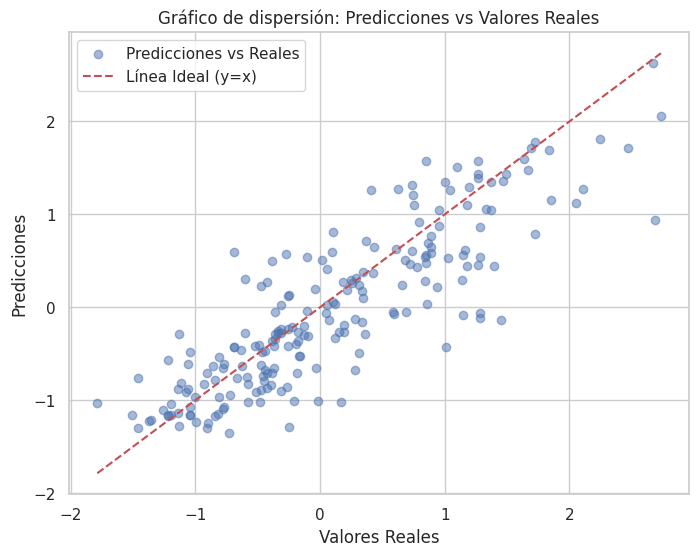

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Predicciones del modelo
y_pred = best_model.predict(X_test)

# Gráfico de dispersión
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicciones vs Reales")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Línea Ideal (y=x)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Gráfico de dispersión: Predicciones vs Valores Reales")
plt.legend()
plt.show()

- Los puntos están generalmente alineados y cercanos a la línea roja (línea ideal), lo que indica que esas predicciones son precisas.

- Las predicciones que se encuentran muy dispersas respecto a la línea, pueden indicar un sesgo.

### 4.1.2 Gráfico de residuales

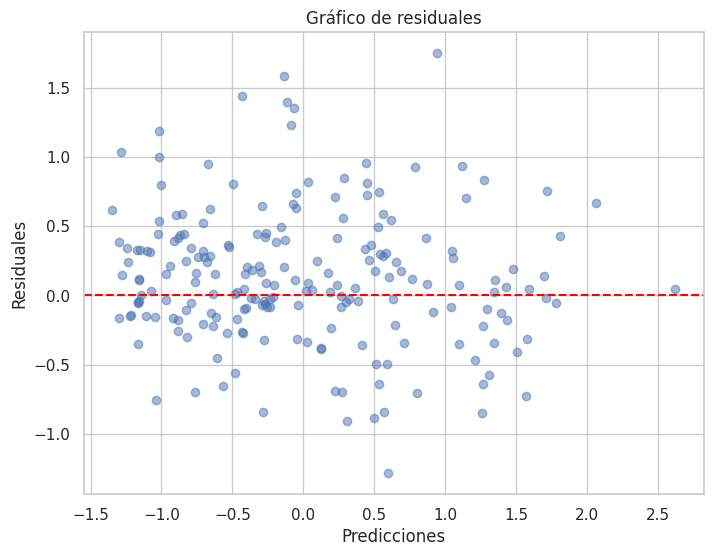

In [30]:
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuales")
plt.title("Gráfico de residuales")
plt.show()

- Los puntos están dispersos aleatoriamente, lo que indica que el modelo está bien ajustado.

- Si hubiera una tendencia clara (por ejemplo, un patrón en forma de U), el modelo podría necesitar ajustes.

### 4.1.3 Boxplot de errores

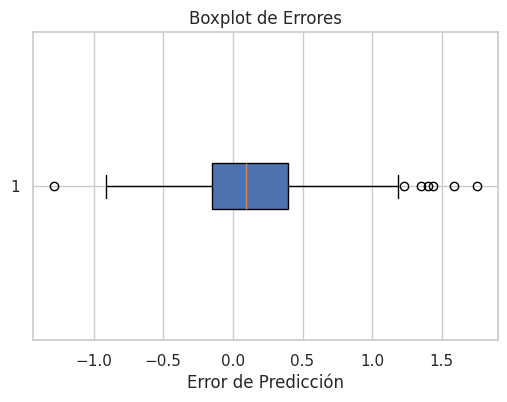

In [31]:
plt.figure(figsize=(6,4))
plt.boxplot(residuals, vert=False, patch_artist=True)
plt.xlabel("Error de Predicción")
plt.title("Boxplot de Errores")
plt.show()

- Los puntos que se encuentran muy alejados, podrían ser _outliers_ en los errores.

### 4.1.4 Curva de aprendizaje

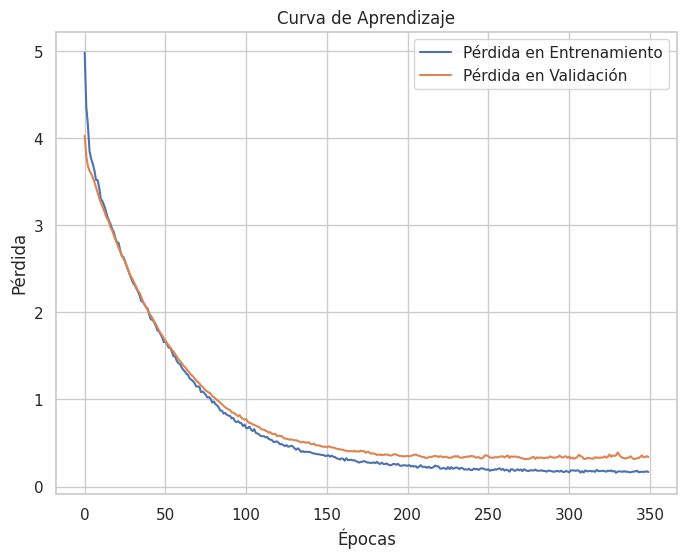

In [32]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Curva de Aprendizaje")
plt.legend()
plt.show()

- Si la pérdida de validación es mucho mayor que la de entrenamiento → Sobreajuste.

- Si ambas pérdidas son altas → El modelo podría ser demasiado simple.

## 4.2 Análisis de errores

### 4.2.1 Predicciones con errores mayores al 10%

In [33]:
# Asegurar que y_test y y_pred sean 1D
y_test = np.ravel(y_test)  # Convierte a 1D si es necesario
y_pred = np.ravel(y_pred)  # Convierte a 1D si es necesario

# Calcular el error relativo
errores_relativos = np.abs((y_test - y_pred) / y_test)

# Filtrar los casos con errores > 10%
errores_significativos = errores_relativos > 0.10

# Mostrar ejemplos de predicciones con alto error
errores_df = pd.DataFrame({
    "Real": y_test,
    "Predicción": y_pred,
    "Error Relativo (%)": errores_relativos * 100
})

errores_df_significativos = errores_df[errores_significativos].sort_values(by="Error Relativo (%)", ascending=False)

print(errores_df_significativos.head(10))  # Ver los 10 peores casos

         Real  Predicción  Error Relativo (%)
27  -0.013911   -1.014132         7190.254752
192  0.012126    0.510879         4112.950764
97  -0.031771   -0.655259         1962.417371
92   0.165769   -1.020077          715.361650
44   0.099922    0.805035          705.662932
62   0.056024    0.411967          635.336725
47  -0.102644    0.535159          621.376050
151 -0.039263    0.197293          602.492868
89   0.095532    0.589741          517.321576
69  -0.251260   -1.286433          411.991760


### 4.2.2 Distribución de los errores relativos

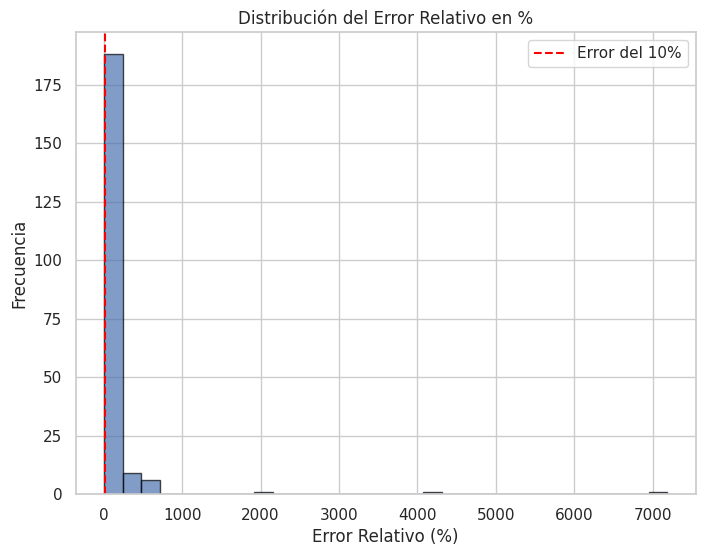

In [34]:
plt.figure(figsize=(8,6))
plt.hist(errores_relativos * 100, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(x=10, color="red", linestyle="--", label="Error del 10%")
plt.xlabel("Error Relativo (%)")
plt.ylabel("Frecuencia")
plt.title("Distribución del Error Relativo en %")
plt.legend()
plt.show()

# 5 Serialización del modelo

In [35]:
# Guardado en formato Keras (.keras)
final_model.save("housing_price_model_v2.keras")

In [36]:
# Guardado en formato HDF5 (.h5)
final_model.save('housing_price_model_v2.h5')

In [37]:
import tensorflow as tf

# Cargar el modelo keras y revisar su shape
loaded_model = tf.keras.models.load_model('housing_price_model_v2.keras')
print(loaded_model.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,533 (88.02 KB)

 Trainable params: 7,425 (29.00 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 14,852 (58.02 KB)

None


# 6 Datos para probar la API del modelo

In [66]:
import random
import json
import numpy as np
import pandas as pd

# Asumiendo que X_test e y_test son DataFrames de pandas
# Si no lo son, tendrás que convertirlos

# Asegurarse de que y_test es un DataFrame
if not isinstance(y_test, pd.DataFrame):
    y_test = pd.DataFrame(y_test)

# Seleccionar un índice aleatorio del conjunto de datos de prueba
random_index = random.randint(0, len(X_test) - 1)

# Extraer las características de ese registro
random_features = X_test.iloc[random_index].values.tolist()

# Obtener el precio real normalizado
real_price_normalized = y_test.iloc[random_index].values[0]

# Crear predicción con el modelo
input_data = np.array([random_features])
prediction = loaded_model.predict(input_data)[0][0]

# Desnormalizar tanto el precio real como la predicción usando la media y desviación estándar
real_price = real_price_normalized * std_price + mean_price
predicted_price = prediction * std_price + mean_price

# Calcular el porcentaje de error
error_percentage = abs((real_price - predicted_price) / real_price) * 100

# Crear el objeto JSON con las características
json_data = {
    "features": random_features
}

# Mostrar el JSON y los precios
print("Registro aleatorio (JSON):")
print(json.dumps(json_data, indent=2))
print("\nPrecio real: ${:,.2f}".format(real_price))
print("Precio predicción: ${:,.2f}".format(predicted_price))
print(f"Error: {error_percentage:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Registro aleatorio (JSON):
{
  "features": [
    -0.03208062213942814,
    1.4477487605705137,
    1.5942864772191023,
    -0.9166666666666667,
    1.0,
    0.0,
    1.0,
    0.0,
    -0.788287141710248,
    0.0,
    0.0,
    1.0,
    0.0
  ]
}

Precio real: $4,893,276.18
Precio predicción: $4,948,301.15
Error: 1.12%
